In [1]:
from quantecon import compute_fixed_point
from quantecon.markov import tauchen

import numpy as np
from numba import njit
from collections import namedtuple


# NamedTuple Model
Model = namedtuple("Model", ("β", "θ", "ρ", "σ", "r", "x_vals", "P"))


def create_rs_utility_model(
        n=180,      # size of state space
        β=0.95,     # time discount factor
        ρ=0.96,     # correlation coef in AR(1)
        σ=0.1,      # volatility
        θ=-1.0):    # risk aversion
    mc = tauchen(ρ, σ, 0, 10, n)  # n_std = 10
    x_vals, P = mc.state_values, mc.P
    r = x_vals      # special case u(c(x)) = x
    return Model(β=β, θ=θ, ρ=ρ, σ=σ, r=r, x_vals=x_vals, P=P)


@njit
def K(v, model):
    β, θ, ρ, σ, r, x_vals, P = model
    return r + (β/θ) * np.log(np.dot(P, (np.exp(θ*v))))


def compute_rs_utility(model):
    β, θ, ρ, σ, r, x_vals, P = model
    v_init = np.zeros(len(x_vals))
    v_star = compute_fixed_point(lambda v: K(v, model), v_init,
                                 error_tol=1e-10, max_iter=1000, print_skip=25)
    return v_star


# Plots


import matplotlib.pyplot as plt


def plot_v(savefig=False,
           figname="../figures/rs_utility_1.pdf"):

    fig, ax = plt.subplots(figsize=(10, 5.2))
    model = create_rs_utility_model()
    β, θ, ρ, σ, r, x_vals, P = model

    a = 1/(1 - (ρ*β))
    b = (β /(1 - β)) * (θ/2) * (a*σ)**2

    v_star = compute_rs_utility(model)
    v_star_a = a * x_vals + b
    ax.plot(x_vals, v_star, linewidth=2, alpha=0.7,
            label="approximate fixed point")
    ax.plot(x_vals, v_star_a, "k--", linewidth=2, alpha=0.7,
            label=r"$v(x)=ax + b$")
    ax.set_xlabel(r"$x$")

    ax.legend(frameon=False, loc="upper left")
    if savefig:
        fig.savefig(figname)


def plot_multiple_v(savefig=False,
                    figname="../figures/rs_utility_2.pdf"):

    fig, ax = plt.subplots(figsize=(10, 5.2))
    σ_vals = 0.05, 0.1

    for σ in σ_vals:
        model = create_rs_utility_model(σ=σ)
        β, θ, ρ, σ, r, x_vals, P  = model
        v_star = compute_rs_utility(model)
        ax.plot(x_vals, v_star, linewidth=2, alpha=0.7,
                label=r"$\sigma=$" + f"{σ}")
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$v(x)$")

    ax.legend(frameon=False, loc="upper left")
    if savefig:
        fig.savefig(figname)

C:\Users\orect\AppData\Local\Temp\ipykernel_14184\2502468528.py:19: UserWarning: The API of tauchen has changed from `tauchen(rho, sigma_u, b=0., m=3, n=7)` to `tauchen(n, rho, sigma, mu=0., n_std=3)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = tauchen(ρ, σ, 0, 10, n)  # n_std = 10


TypeError: 'float' object cannot be interpreted as an integer

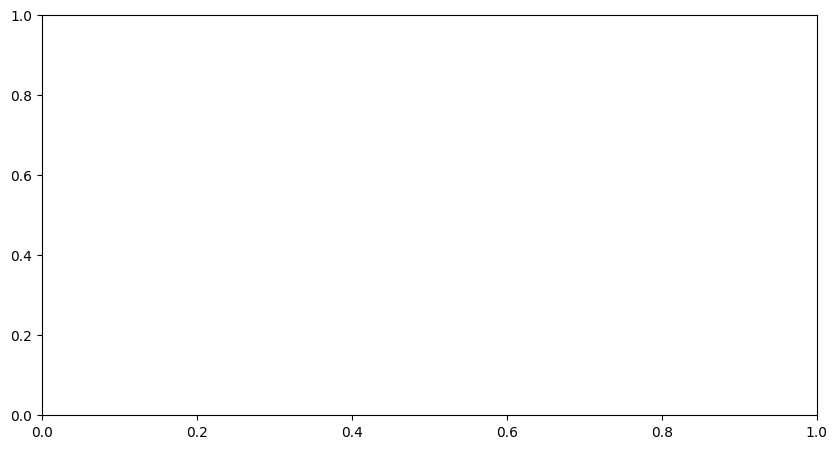

In [2]:
plot_v(savefig=True)

C:\Users\orect\AppData\Local\Temp\ipykernel_14184\2502468528.py:19: UserWarning: The API of tauchen has changed from `tauchen(rho, sigma_u, b=0., m=3, n=7)` to `tauchen(n, rho, sigma, mu=0., n_std=3)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = tauchen(ρ, σ, 0, 10, n)  # n_std = 10


TypeError: 'float' object cannot be interpreted as an integer

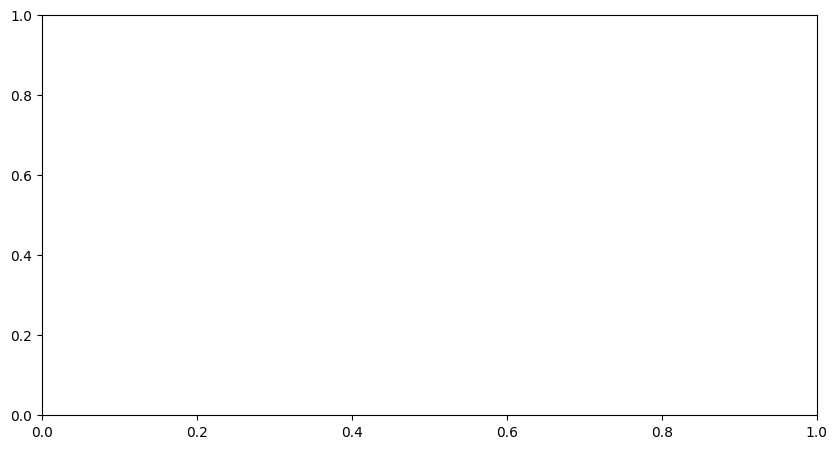

In [3]:
plot_multiple_v(savefig=True)

In [4]:
"""
Epstein--Zin utility: solving the recursion for a given consumption
path.

"""

from quantecon import compute_fixed_point
from quantecon.markov import tauchen

import numpy as np
from numba import njit
from collections import namedtuple


# NamedTuple Model
Model = namedtuple("Model", ("β", "ρ", "σ", "α", "γ", "c", "x_vals", "P"))


def create_ez_utility_model(
        n=200,      # size of state space
        ρ=0.96,     # correlation coef in AR(1)
        σ=0.1,      # volatility
        β=0.99,     # time discount factor
        α=0.75,     # EIS parameter
        γ=-2.0):    # risk aversion parameter
    mc = tauchen(ρ, σ, 0, 5, n)
    x_vals, P = mc.state_values, mc.P
    c = np.exp(x_vals)
    return Model(β=β, ρ=ρ, σ=σ, α=α, γ=γ, c=c, x_vals=x_vals, P=P)


@njit
def K(v, model):
    β, ρ, σ, α, γ, c, x_vals, P = model
    R = np.dot(P, v**γ)**(1/γ)
    return ((1 - β) * c**α + β * R**α)**(1/α)


def compute_ez_utility(model):
    v_init = np.ones(len(model.x_vals))
    v_star = compute_fixed_point(lambda v: K(v, model), v_init,
                                 error_tol=1e-6, max_iter=1000, print_skip=100)
    return v_star



# Plots


import matplotlib.pyplot as plt


def plot_convergence(savefig=False,
                     num_iter=100,
                     figname="../figures/ez_utility_c.pdf"):

    fig, ax = plt.subplots(figsize=(10, 5.2))
    model = create_ez_utility_model()
    β, ρ, σ, α, γ, c, x_vals, P = model


    v_star = compute_ez_utility(model)
    v = 0.1 * v_star
    ax.plot(x_vals, v, "k-", linewidth=3, alpha=0.7, label=r"$v_0$")

    greys = [str(g) for g in np.linspace(0.0, 0.4, num_iter)]
    greys.reverse()

    for g in greys:
        ax.plot(x_vals, v, "k-", color=g, linewidth=1, alpha=0.7)
        for t in range(20):
            v = K(v, model)

    v_star = compute_ez_utility(model)
    ax.plot(x_vals, v_star, linewidth=3, alpha=0.7, label=r"$v^*$")
    ax.set_xlabel(r"$x$")

    ax.legend(frameon=False, loc="upper left")
    if savefig:
        fig.savefig(figname)


def plot_v(savefig=False,
           figname="../figures/ez_utility_1.pdf"):

    fig, ax = plt.subplots(figsize=(10, 5.2))
    model = create_ez_utility_model()
    β, ρ, σ, α, γ, c, x_vals, P = model
    v_star = compute_ez_utility(model)
    ax.plot(x_vals, v_star, linewidth=2, alpha=0.7, label=r"$v^*$")
    ax.set_xlabel(r"$x$")

    ax.legend(frameon=False, loc="upper left")
    if savefig:
        fig.savefig(figname)


def vary_gamma(gamma_vals=[1.0, -8.0],
               savefig=False,
               figname="../figures/ez_utility_2.pdf"):

    fig, ax = plt.subplots(figsize=(10, 5.2))

    for γ in gamma_vals:
        model = create_ez_utility_model(γ=γ)
        β, ρ, σ, α, γ, c, x_vals, P = model
        v_star = compute_ez_utility(model)
        ax.plot(x_vals, v_star, linewidth=2, alpha=0.7, label=r"$\gamma=$" + f"{γ}")
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$v(x)$")

    ax.legend(frameon=False, loc="upper left")
    if savefig:
        fig.savefig(figname)


def vary_alpha(alpha_vals=[0.5, 0.6],
               savefig=False,
               figname="../figures/ez_utility_3.pdf"):

    fig, ax = plt.subplots(figsize=(10, 5.2))

    for α in alpha_vals:
        model = create_ez_utility_model(α=α)
        β, ρ, σ, α, γ, c, x_vals, P = model
        v_star = compute_ez_utility(model)
        ax.plot(x_vals, v_star, linewidth=2, alpha=0.7, label=r"$\alpha=$"+f"{α}")
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$v(x)$")

    ax.legend(frameon=False, loc="upper left")
    if savefig:
        fig.savefig(figname)

C:\Users\orect\AppData\Local\Temp\ipykernel_14184\2981158399.py:26: UserWarning: The API of tauchen has changed from `tauchen(rho, sigma_u, b=0., m=3, n=7)` to `tauchen(n, rho, sigma, mu=0., n_std=3)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = tauchen(ρ, σ, 0, 5, n)


TypeError: 'float' object cannot be interpreted as an integer

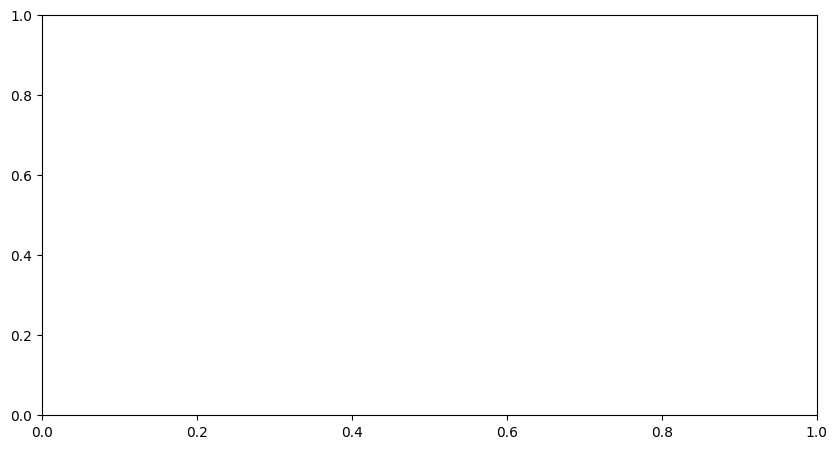

In [5]:
plot_convergence(savefig=True)

C:\Users\orect\AppData\Local\Temp\ipykernel_14184\2981158399.py:26: UserWarning: The API of tauchen has changed from `tauchen(rho, sigma_u, b=0., m=3, n=7)` to `tauchen(n, rho, sigma, mu=0., n_std=3)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = tauchen(ρ, σ, 0, 5, n)


TypeError: 'float' object cannot be interpreted as an integer

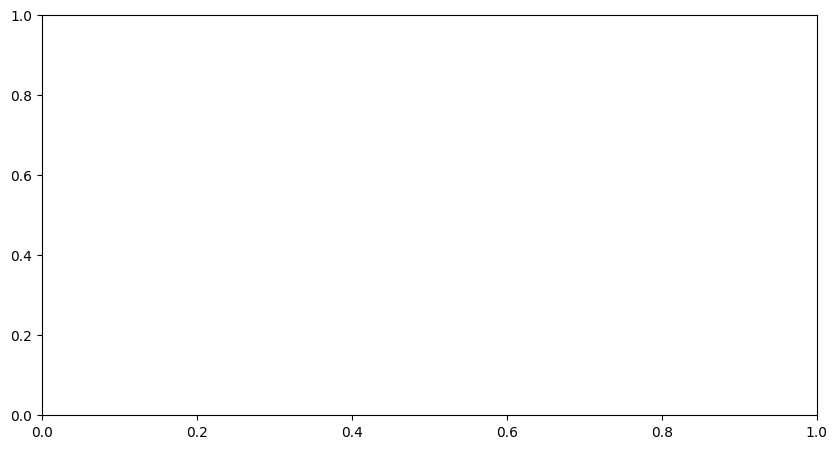

In [6]:
plot_v(savefig=True)

C:\Users\orect\AppData\Local\Temp\ipykernel_14184\2981158399.py:26: UserWarning: The API of tauchen has changed from `tauchen(rho, sigma_u, b=0., m=3, n=7)` to `tauchen(n, rho, sigma, mu=0., n_std=3)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = tauchen(ρ, σ, 0, 5, n)


TypeError: 'float' object cannot be interpreted as an integer

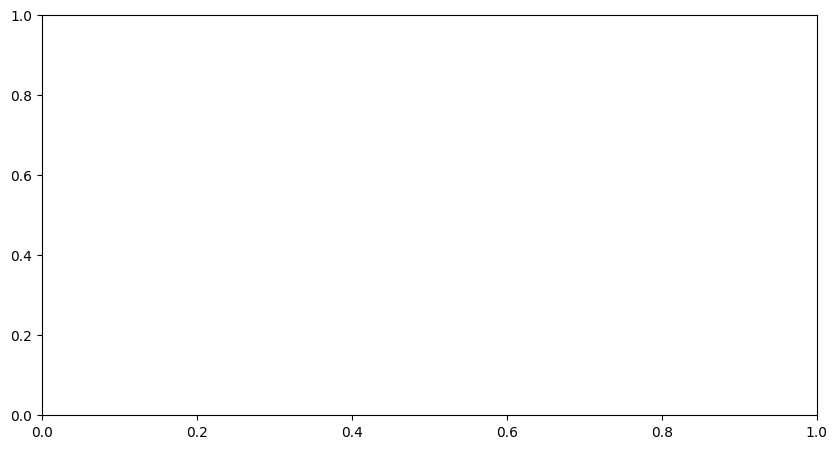

In [7]:
vary_gamma(savefig=True)

C:\Users\orect\AppData\Local\Temp\ipykernel_14184\2981158399.py:26: UserWarning: The API of tauchen has changed from `tauchen(rho, sigma_u, b=0., m=3, n=7)` to `tauchen(n, rho, sigma, mu=0., n_std=3)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = tauchen(ρ, σ, 0, 5, n)


TypeError: 'float' object cannot be interpreted as an integer

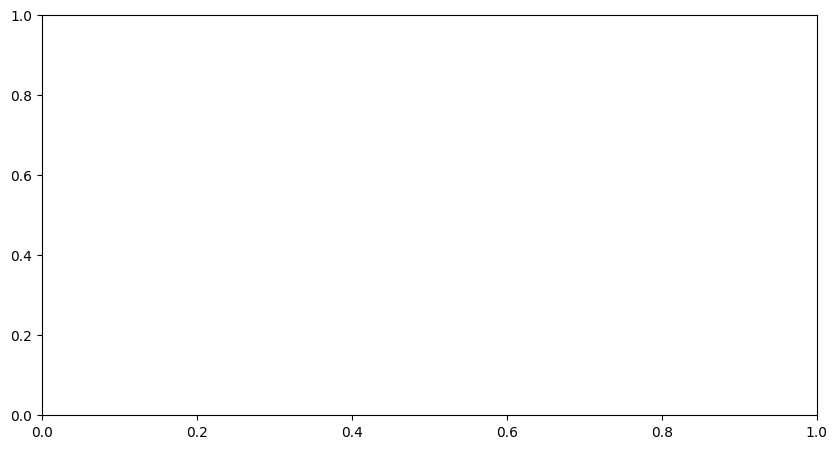

In [8]:
vary_alpha(savefig=True)